# Trabajo Practico 1
## Maximización del Ratio de Sharpe con Derivadas Numéricas

El ratio de Sharpe está definido como:

$$
S(w) = \frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}
$$

donde:

- **\( w \)** es el vector de pesos del portafolio,  
- **\( \mu \)** es el vector de rendimientos esperados,  
- **\( r_f \)** es la tasa libre de riesgo,  
- **\( \Sigma \)** es la matriz de covarianzas.

# Ejercicio 1

In [23]:
import numpy as np
import matplotlib.pyplot as plt


class Portfolio():
    def __init__(self, weights, returns, rf):
        # Weighst = tupla con los w de los 3 activos
        # Returns = Lista de 3 tuplas con los retornos de los 3 activos
        self.returns = np.array(returns)
        self.mus = self.mu()
        self.weights = self.check_weights(weights)
        self.rf = rf
        self.cov_matrix = np.cov(returns)

    def check_weights(self, weights):
        check = 0
        for i in weights:
            check += i
        if check != 1:
            raise ValueError("La suma de los weights debe ser 1.")

        # Si vienen 2 weights, infiero el tercero
        if len(weights)==2:
            weights = np.append(weights, 1-weights.sum())
        return np.array(weights)

    def mu(self):
        prom_r = []
        for i in self.returns:
            i = np.mean(i)
            prom_r.append(i)
        return np.array(prom_r)

    def portfolio_return(self, weights=None):
        if weights is None:
            weights = self.weights
        return weights @ self.mus

    def portfolio_volatility(self, weights=None):
        if weights is None:
            weights = self.weights
        return np.sqrt(weights @ self.cov_matrix @ weights)

    def sharpe_ratio(self, weights=None): #cambiar nombre a menos sharpe/o agregar un parametro que haga el return negativo
        if weights is None:
            weights = self.weights
        elif len(weights)==2:
            weights = np.append(weights,1-sum(weights))
        return -(self.portfolio_return(weights) - self.rf) / self.portfolio_volatility(weights)
    
weights = (0.1, 0.5, 0.4)
returns = [
    (0.10, 0.20, 0.15, 0.12, -0.10),
    (0.05, 0.10, 0.12, 0.08, -0.05),
    (0.20, 0.25, 0.22, 0.21,  0.15),
]
rf = 0.03
p = Portfolio(weights, returns, rf)

print("Sharpe Ratio:", p.sharpe_ratio())
print("Portfolio Return:", p.portfolio_return())


Sharpe Ratio: -1.5721160315356602
Portfolio Return: 0.12180000000000002


# Ejercicio 2

Óptimo: [-0.52388295  0.21212792  1.31175504] Sharpe: 22.42783834420706


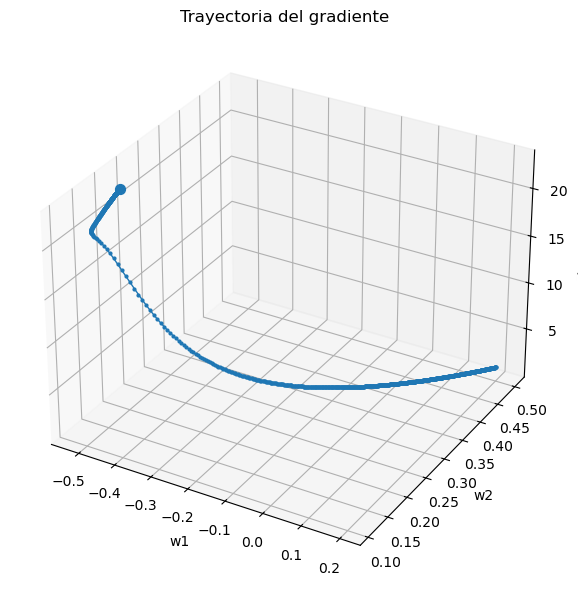

In [22]:
#Punto 2     
def gradient_sharpe(cartera, w, Penalty = False):
        """
        Esta función hace la derivada centrada del
        ratio de Sharpe, evaluada en el punto que
        el usuario ingrese.
        Por default usa como funcion a derivar el 
        ratio de sharpe sin la penalidad, pero el 
        usuario puede elegir si desea derivar la 
        funcion que involucra la penalidad cuando
        alguno de los weights son < 0.
        
        Returns: Gradiente
        """
        h = 10e-4  # El movimiento marginal de la derivada
        if w is None:
            w = cartera.weights[:2:]
        #Derivada parcial resp de w1:
        
        fx = (cartera.sharpe_ratio(np.array([w[0] + h, w[1]])) - cartera.sharpe_ratio(np.array([w[0] - h, w[1]])))/(2*h)
        #Derivada parcial resp de w2:
        fy = (cartera.sharpe_ratio(np.array([w[0], w[1] + h])) - cartera.sharpe_ratio(np.array([w[0], w[1] - h])))/(2*h)

        return np.array([fx, fy]) #Gradiente

def gdscent(cartera, e = 10e-5,n=100000,graph=False):
    """ Esta función recibe por parte del usuario un vector de ponderadores inicial del portafolio. Mediante el uso de derivadas 
    centradas y el algoritmo de descenso por gradiente de -f(X) maximiza el ratio de Sharpe. """

    # En cada iteración, se debera crear un nuevo vector de weights que se convertira otro objeto de la clase Portfolio.
    # Los retornos y la risk free se mantienen con el mismo valor (W0).
    w0 = cartera.weights[:2:]
    rf = cartera.rf
    w=np.array([])
    sharps=np.array([])
    # Evaluo el sharpe en el punto W0
    # Agregamos un menos adelante, porque queremos maximizar una función con un metodo de minimizacion
    for i in range(n):
        Y0 = cartera.sharpe_ratio(w0) 

        # Calculo la derivada centrada en W0
        dY = gradient_sharpe(cartera, w0)

        # Calculo mi nuevo w0 retrocediendo a tasa e en contra del gradiente, la direccion de maximo crecimiento
        w0 = w0 - e * (dY)

        # Evaluo el shrape en mi nuevo punto W1
        Y1 = cartera.sharpe_ratio(w0)
        
        #Si la distancia en valor absoluto entre f(W1) y f(W0) es muy chica, decimos que encontramos el vector de weights que maximiza el sharpe dada una rf
        if abs(Y1-Y0) < 10e-8:
            w0 = np.append(w0,1-sum(w0))
            sharp = cartera.sharpe_ratio(w0)
            if graph:
                 return w0 , -sharp, w, sharps
            return w0 , -sharp,
        else:
            w = np.append(w, [ [w0[0], w0[1]] ])
            sharps = np.append(sharps,-Y1)
            continue

def graph_3d(cartera, path, sharps_path):
    import numpy as np
    import matplotlib.pyplot as plt

    path = np.asarray(path)
    if path.ndim == 1:
        if path.size % 2 != 0:
            raise ValueError("La trayectoria 'path' debe tener cantidad par de elementos.")
        path = path.reshape(-1, 2)

    sharps_path = np.asarray(sharps_path)
    if sharps_path.ndim != 1 or sharps_path.size != path.shape[0]:
        raise ValueError("Len(sharps_path) debe coincidir con filas de 'path'.")

    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    # solo la trayectoria (sin plano/superficie)
    ax.plot(path[:, 0], path[:, 1], sharps_path, marker='o', markersize=2, linewidth=1)
    ax.scatter(path[-1, 0], path[-1, 1], sharps_path[-1], s=50)

    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('Sharpe')
    ax.set_title('Trayectoria del gradiente')
    plt.tight_layout()
    plt.show()

##### Pruebas #####        
weights = (0.2, 0.5, 0.3)
returns = [(0.1, 0.2, 0.15, 0.12, -0.1), (0.05, 0.1, 0.12, 0.08, -0.05), (0.2, 0.25, 0.22, 0.21, 0.15)]
rf = 0.03
p = Portfolio(weights, returns, rf)


w_opt, sharpe_opt, path, sharps_path = gdscent(p, graph=True)
print("Óptimo:", w_opt, "Sharpe:", sharpe_opt)

graph_3d(p, path, sharps_path)